In [1]:
import random  # for reproducibility in sampling and shuffling
from pathlib import Path  # filesystem path manipulation

# 2. Data handling and preprocessing
import numpy as np  # numerical operations
import pandas as pd  # dataframes and tabular data

# 3. Visualization
import matplotlib.pyplot as plt  # plotting
import seaborn as sns  # statistical data visualization

# 4. Deep learning (PyTorch)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# 5. Machine learning utilities (scikit-learn)
from sklearn.preprocessing import LabelEncoder, StandardScaler  # encoding labels and feature scaling
from sklearn.model_selection import train_test_split  # data splitting
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score  # evaluation metrics

# 6. Learning rate schedulers
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, OneCycleLR, CosineAnnealingLR, CosineAnnealingWarmRestarts  # dynamic LR scheduling

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Configure seaborn aesthetics
sns.set(style='whitegrid', context='notebook')

In [2]:
# Dataset file paths
TRAIN_CSV = "/kaggle/input/har-dataset-2/train_data_2.csv"  # Path to training data CSV
TEST_CSV  = "/kaggle/input/har-dataset-2/test_data_2.csv"   # Path to testing data CSV

# Windowing and batching parameters
WINDOW_SIZE = 600           # Number of timesteps per sliding window
BATCH_SIZE = 32             # Number of samples per training batch
SAMPLING_FREQ = 200         # Data sampling frequency in Hz
ADD_FEATS = False           # Whether to add derived features beyond raw sensor data

# Detect compute device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Processing Utilities and Dataset Preparation
This cell defines utility functions to select sensor channels, split data into training and validation sets, and loads, preprocesses, encodes, and wraps data in PyTorch datasets and dataloaders.

In [3]:
class DataPreprocessor:
    def __init__(self, window_size=600, sampling_freq=200, target_samples=32):
        self.window_size = window_size
        self.sampling_freq = sampling_freq
        self.target_samples = target_samples

    def moving_average_filter(self, data, window=8):
        return data.rolling(window=window, center=True).mean().fillna(data)

    def segment_data(self, data, overlap=0.7):
        segments = []
        labels_io = []
        labels_scene = []
        step_size = int(self.window_size * (1 - overlap))

        for i in range(0, len(data) - self.window_size, step_size):
            window = data.iloc[i:i+self.window_size]

            if len(window['I/O Detection'].unique()) == 1 and \
               len(window['Scene Identification'].unique()) == 1:
                segments.append(window)
                labels_io.append(window['I/O Detection'].iloc[0])
                labels_scene.append(window['Scene Identification'].iloc[0])

        return segments, labels_io, labels_scene

    def downsample_segment(self, segment, sensor_cols):
        downsampled = {}
        for col in sensor_cols:
            if col in segment.columns:
                original_data = segment[col].values
                indices = np.linspace(0, len(original_data) - 1, self.target_samples, dtype=int)
                downsampled[col] = original_data[indices]
            else:
                downsampled[col] = np.zeros(self.target_samples)
        return downsampled

    def z_score_normalize(self, segment_data):
        segment_array = np.array(list(segment_data.values())).T
        mean = np.mean(segment_array, axis=0)
        std = np.std(segment_array, axis=0)
        std = np.where(std == 0, 1, std)
        return (segment_array - mean) / std

    def extract_statistical_features(self, segment, sensor_cols):
        features = []
        for col in sensor_cols:
            if col in segment.columns:
                values = segment[col].values
                features.extend([
                    np.mean(values),
                    np.std(values),
                    np.min(values),
                    np.max(values)
                ])
        return features

    def preprocess_data(self, data, sensor_cols):
        filtered_data = data.copy()
        for col in sensor_cols:
            if col in data.columns:
                filtered_data[col] = self.moving_average_filter(data[col])

        segments, labels_io, labels_scene = self.segment_data(filtered_data)

        processed_segments = []
        statistical_features = []

        for segment in segments:
            if self.target_samples is not None:
                downsampled = self.downsample_segment(segment, sensor_cols)
                normalized = self.z_score_normalize(downsampled)
                processed_segments.append(normalized)
            else:
                processed_segments.append(segment[sensor_cols].values)

            stats = self.extract_statistical_features(segment, sensor_cols)
            statistical_features.append(stats)

        return np.array(processed_segments), np.array(statistical_features), labels_io, labels_scene

class HARDSdataset(Dataset):
    def __init__(self, X, y_io, y_scene, io_label_encoder, scene_label_encoder, statistical_features=None):
        self.X = torch.FloatTensor(X)
        self.y_io = torch.LongTensor(y_io)
        self.y_scene = torch.LongTensor(y_scene)
        self.statistical_features = statistical_features
        if statistical_features is not None:
            self.statistical_features = torch.FloatTensor(statistical_features)
        self.io_label_encoder = io_label_encoder
        self.scene_label_encoder = scene_label_encoder
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if self.statistical_features is not None:
            return self.X[idx], self.y_io[idx], self.y_scene[idx], self.statistical_features[idx]
        return self.X[idx], self.y_io[idx], self.y_scene[idx]

In [4]:
# Function to map high-level sensor names to their corresponding DataFrame columns
def get_sensors(sensor_list):
    # Dictionary of available sensor groups and their DataFrame columns
    available_sensors = {
        "Accelerometer": ["A_x [g]_y", "A_y [g]_y", "A_z [g]_y"],
        "Magnetometer": ["M_x [gauss]", "M_y [gauss]", "M_z [gauss]"],
        "Gyroscope": ["G_x [mdps]", "G_y [mdps]", "G_z [mdps]"],
        "Temperature": ["TEMP"],
        "Pressure": ["PRESS"],
    }

    # If user requests all sensors, return every column
    if sensor_list == 'all':
        return [col for cols in available_sensors.values() for col in cols]

    selected_sensors = []
    # Iterate through requested sensor names
    for sensor in sensor_list:
        # Raise error if sensor name is invalid
        if sensor not in available_sensors:
            raise ValueError(
                f"Sensor '{sensor}' is not available. Choose from {list(available_sensors.keys())}"
            )
        # Append all columns for the valid sensor
        selected_sensors.extend(available_sensors[sensor])

    return selected_sensors

# Function to split data arrays into train and validation subsets
def split_train_validation(X, y_io, y_scene, stats, val_split=0.2, stratify_on=None):
    # Use stratified split if a column is provided for stratification
    if stratify_on is not None:
        X_train, X_val, y_io_train, y_io_val, y_scene_train, y_scene_val, stats_train, stats_val = train_test_split(
            X, y_io, y_scene, stats,
            test_size=val_split,
            random_state=42,
            stratify=stratify_on
        )
    else:
        # Simple contiguous split if no stratification
        split_idx = int((1 - val_split) * len(X))
        X_train, X_val = X[:split_idx], X[split_idx:]
        y_io_train, y_io_val = y_io[:split_idx], y_io[split_idx:]
        y_scene_train, y_scene_val = y_scene[:split_idx], y_scene[split_idx:]
        stats_train, stats_val = stats[:split_idx], stats[split_idx:]

    return (
        X_train, X_val,
        y_io_train, y_io_val,
        y_scene_train, y_scene_val,
        stats_train, stats_val
    )

def print_distribution(name, labels, encoder):
    # labels: 1D array of encoded ints
    unique_lbls, counts = np.unique(labels, return_counts=True)
    print(f"\n=== {name} Set ===")
    for enc, cnt in zip(unique_lbls, counts):
        human = encoder.inverse_transform([enc])[0]
        print(f"  {human:>10s}: {cnt}")

# Prepare sensor list and data preprocessor
sensors = get_sensors('all')  # Retrieve all sensor columns
preprocessor = DataPreprocessor(window_size=WINDOW_SIZE, target_samples=None)

# Load raw CSV data
train_data = pd.read_csv(TRAIN_CSV)
test_data = pd.read_csv(TEST_CSV)

# Preprocess data into feature windows, stats, and labels
X_train, stats_train, y_io_train, y_scene_train = preprocessor.preprocess_data(train_data, sensors)
X_test, stats_test, y_io_test, y_scene_test = preprocessor.preprocess_data(test_data, sensors)

# Print data shapes and unique classes for sanity
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Unique I/O classes: {np.unique(y_io_train)}")
print(f"Unique Scene classes: {np.unique(y_scene_train)}")

# Encode string labels to integers for I/O and Scene tasks
io_encoder = LabelEncoder()
scene_encoder = LabelEncoder()

y_io_train_encoded = io_encoder.fit_transform(y_io_train)
y_scene_train_encoded = scene_encoder.fit_transform(y_scene_train)
y_io_test_encoded = io_encoder.transform(y_io_test)
y_scene_test_encoded = scene_encoder.transform(y_scene_test)

# Number of classes for each task
num_io_classes = len(io_encoder.classes_)
num_scene_classes = len(scene_encoder.classes_)

print(f"Number of I/O classes: {num_io_classes}")
print(f"Number of Scene classes: {num_scene_classes}")

# Split data into training and validation sets
X_train_split, X_val, y_io_train_split, y_io_val, y_scene_train_split, y_scene_val, stats_train_split, stats_val = split_train_validation(
    X_train, y_io_train_encoded, y_scene_train_encoded,
    stats_train,
    val_split=0.2,
    stratify_on=y_scene_train_encoded  # Stratify by scene class distribution
)

# Decode validation labels for potential inspection or debugging
y_io_val_decoded = io_encoder.inverse_transform(y_io_val)
y_scene_val_decoded = scene_encoder.inverse_transform(y_scene_val)

# %% [code]
# Create PyTorch datasets for train, validation, and test splits
train_dataset = HARDSdataset(X_train_split, y_io_train_split, y_scene_train_split, io_encoder, scene_encoder)
val_dataset = HARDSdataset(X_val, y_io_val, y_scene_val, io_encoder, scene_encoder)
test_dataset = HARDSdataset(X_test, y_io_test_encoded, y_scene_test_encoded, io_encoder, scene_encoder)

# Build DataLoaders for batching during training and evaluation
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)

# Print dataset sizes for verification
print(f"Train samples: {len(train_loader.dataset)}")
print(f"Val samples:   {len(val_loader.dataset)}")
print(f"Test samples:  {len(test_loader.dataset)}")

# Print dataset labels distributions
print_distribution("Train I/O",   train_dataset.y_io,    train_dataset.io_label_encoder)
print_distribution("Train Scene", train_dataset.y_scene, train_dataset.scene_label_encoder)

print_distribution("Val I/O",     val_dataset.y_io,      val_dataset.io_label_encoder)
print_distribution("Val Scene",   val_dataset.y_scene,   val_dataset.scene_label_encoder)

print_distribution("Test I/O",    test_dataset.y_io,     test_dataset.io_label_encoder)
print_distribution("Test Scene",  test_dataset.y_scene,  test_dataset.scene_label_encoder)

Training data shape: (21476, 600, 11)
Test data shape: (5342, 600, 11)
Unique I/O classes: ['Indoor' 'Outdoor']
Unique Scene classes: ['Bar' 'Hallway' 'Office' 'Street']
Number of I/O classes: 2
Number of Scene classes: 4
Train samples: 17180
Val samples:   4296
Test samples:  5342

=== Train I/O Set ===
      Indoor: 12321
     Outdoor: 4859

=== Train Scene Set ===
         Bar: 4000
     Hallway: 2611
      Office: 5710
      Street: 4859

=== Val I/O Set ===
      Indoor: 3081
     Outdoor: 1215

=== Val Scene Set ===
         Bar: 1000
     Hallway: 653
      Office: 1428
      Street: 1215

=== Test I/O Set ===
      Indoor: 3809
     Outdoor: 1533

=== Test Scene Set ===
         Bar: 828
     Hallway: 1097
      Office: 1884
      Street: 1533


In [7]:
# Access the label encoders from your dataset object
io_encoder = train_loader.dataset.io_label_encoder
scene_encoder = train_loader.dataset.scene_label_encoder

# The .classes_ attribute holds the class names in order of their integer encoding (0, 1, 2, ...)
print("I/O Encoder Classes:", io_encoder.classes_)
print("Scene Encoder Classes:", scene_encoder.classes_)

# For a more robust way to use this in your code, create a mapping dictionary
io_map = {name: i for i, name in enumerate(io_encoder.classes_)}
scene_map = {name: i for i, name in enumerate(scene_encoder.classes_)}

print("\n--- Mappings ---")
print("I/O Mapping:", io_map)
print("Scene Mapping:", scene_map)

# Now you can directly use the names to get the encoding
print(f"\nEncoding for 'Indoor': {io_map['Indoor']}")
print(f"Encoding for 'Outdoor': {io_map['Outdoor']}")

I/O Encoder Classes: ['Indoor' 'Outdoor']
Scene Encoder Classes: ['Bar' 'Hallway' 'Office' 'Street']

--- Mappings ---
I/O Mapping: {'Indoor': 0, 'Outdoor': 1}
Scene Mapping: {'Bar': 0, 'Hallway': 1, 'Office': 2, 'Street': 3}

Encoding for 'Indoor': 0
Encoding for 'Outdoor': 1


# Augmented Dataset

In [69]:
# --- AUGMENTATION FUNCTIONS FOR IMU DATA (CORRECTED) ---

def gaussian_noise(sample, noise_std=0.05):
    """Adds Gaussian noise to the sample."""
    noise = np.random.normal(0, noise_std, sample.shape).astype(np.float32)
    return sample + noise

def scale(sample, scale_range=(0.9, 1.1)):
    """Scales the amplitude of the entire sample."""
    # CORRECTED LINE: Removed .astype() from the float
    scale_factor = np.random.uniform(scale_range[0], scale_range[1])
    return sample * scale_factor

def shift(sample, max_shift_points=30):
    """Randomly shifts the sample in time."""
    shift_points = np.random.randint(-max_shift_points, max_shift_points + 1)
    return np.roll(sample, shift_points, axis=0)

# --- THE NEW DATASET CLASS (No changes here, but included for completeness) ---

class AugmentedHARDSdataset(Dataset):
    def __init__(self, X, y_io, y_scene, io_label_encoder, scene_label_encoder, is_train=False):
        # Store data as NumPy arrays, not tensors
        self.X = X.astype(np.float32) 
        self.y_io = y_io
        self.y_scene = y_scene
        
        # Keep encoders for potential debugging
        self.io_label_encoder = io_label_encoder
        self.scene_label_encoder = scene_label_encoder
        
        # This flag is CRUCIAL. We only augment the training set.
        self.is_train = is_train
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        # Start with the original sample
        sample = self.X[idx]

        # --- Apply augmentations only if this is the training dataset ---
        if self.is_train:
            # Apply a sequence of augmentations.
            # You can add more or change the order.
            sample = gaussian_noise(sample, noise_std=0.05)
            sample = scale(sample, scale_range=(0.8, 1.2))
            sample = shift(sample, max_shift_points=int(sample.shape[0] * 0.1)) # Shift up to 10%
        
        # Convert the final sample to a tensor for the model
        # Labels also need to be converted to tensors here
        return (
            torch.from_numpy(sample),
            torch.as_tensor(self.y_io[idx], dtype=torch.long),
            torch.as_tensor(self.y_scene[idx], dtype=torch.long)
        )

In [70]:
# Function to map high-level sensor names to their corresponding DataFrame columns
def get_sensors(sensor_list):
    # Dictionary of available sensor groups and their DataFrame columns
    available_sensors = {
        "Accelerometer": ["A_x [g]_y", "A_y [g]_y", "A_z [g]_y"],
        "Magnetometer": ["M_x [gauss]", "M_y [gauss]", "M_z [gauss]"],
        "Gyroscope": ["G_x [mdps]", "G_y [mdps]", "G_z [mdps]"],
        "Temperature": ["TEMP"],
        "Pressure": ["PRESS"],
    }

    # If user requests all sensors, return every column
    if sensor_list == 'all':
        return [col for cols in available_sensors.values() for col in cols]

    selected_sensors = []
    # Iterate through requested sensor names
    for sensor in sensor_list:
        # Raise error if sensor name is invalid
        if sensor not in available_sensors:
            raise ValueError(
                f"Sensor '{sensor}' is not available. Choose from {list(available_sensors.keys())}"
            )
        # Append all columns for the valid sensor
        selected_sensors.extend(available_sensors[sensor])

    return selected_sensors

# Function to split data arrays into train and validation subsets
def split_train_validation(X, y_io, y_scene, stats, val_split=0.2, stratify_on=None):
    # Use stratified split if a column is provided for stratification
    if stratify_on is not None:
        X_train, X_val, y_io_train, y_io_val, y_scene_train, y_scene_val, stats_train, stats_val = train_test_split(
            X, y_io, y_scene, stats,
            test_size=val_split,
            random_state=42,
            stratify=stratify_on
        )
    else:
        # Simple contiguous split if no stratification
        split_idx = int((1 - val_split) * len(X))
        X_train, X_val = X[:split_idx], X[split_idx:]
        y_io_train, y_io_val = y_io[:split_idx], y_io[split_idx:]
        y_scene_train, y_scene_val = y_scene[:split_idx], y_scene[split_idx:]
        stats_train, stats_val = stats[:split_idx], stats[split_idx:]

    return (
        X_train, X_val,
        y_io_train, y_io_val,
        y_scene_train, y_scene_val,
        stats_train, stats_val
    )

def print_distribution(name, labels, encoder):
    # labels: 1D array of encoded ints
    unique_lbls, counts = np.unique(labels, return_counts=True)
    print(f"\n=== {name} Set ===")
    for enc, cnt in zip(unique_lbls, counts):
        human = encoder.inverse_transform([enc])[0]
        print(f"  {human:>10s}: {cnt}")

# Prepare sensor list and data preprocessor
sensors = get_sensors('all')  # Retrieve all sensor columns
preprocessor = DataPreprocessor(window_size=WINDOW_SIZE, target_samples=None)

# Load raw CSV data
train_data = pd.read_csv(TRAIN_CSV)
test_data = pd.read_csv(TEST_CSV)

# Preprocess data into feature windows, stats, and labels
X_train, stats_train, y_io_train, y_scene_train = preprocessor.preprocess_data(train_data, sensors)
X_test, stats_test, y_io_test, y_scene_test = preprocessor.preprocess_data(test_data, sensors)

# Print data shapes and unique classes for sanity
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Unique I/O classes: {np.unique(y_io_train)}")
print(f"Unique Scene classes: {np.unique(y_scene_train)}")

# Encode string labels to integers for I/O and Scene tasks
io_encoder = LabelEncoder()
scene_encoder = LabelEncoder()

y_io_train_encoded = io_encoder.fit_transform(y_io_train)
y_scene_train_encoded = scene_encoder.fit_transform(y_scene_train)
y_io_test_encoded = io_encoder.transform(y_io_test)
y_scene_test_encoded = scene_encoder.transform(y_scene_test)

# Number of classes for each task
num_io_classes = len(io_encoder.classes_)
num_scene_classes = len(scene_encoder.classes_)

print(f"Number of I/O classes: {num_io_classes}")
print(f"Number of Scene classes: {num_scene_classes}")

# Split data into training and validation sets
X_train_split, X_val, y_io_train_split, y_io_val, y_scene_train_split, y_scene_val, stats_train_split, stats_val = split_train_validation(
    X_train, y_io_train_encoded, y_scene_train_encoded,
    stats_train,
    val_split=0.2,
    stratify_on=y_scene_train_encoded  # Stratify by scene class distribution
)

# Decode validation labels for potential inspection or debugging
y_io_val_decoded = io_encoder.inverse_transform(y_io_val)
y_scene_val_decoded = scene_encoder.inverse_transform(y_scene_val)

# %% [code]
# Create PyTorch datasets for train, validation, and test splits
train_dataset = AugmentedHARDSdataset(X_train_split, y_io_train_split, y_scene_train_split, io_encoder, scene_encoder, is_train=True)
val_dataset = AugmentedHARDSdataset(X_val, y_io_val, y_scene_val, io_encoder, scene_encoder, is_train=False)
test_dataset = AugmentedHARDSdataset(X_test, y_io_test_encoded, y_scene_test_encoded, io_encoder, scene_encoder, is_train=False)

# Build DataLoaders for batching during training and evaluation
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)

# Print dataset sizes for verification
print(f"Train samples: {len(train_loader.dataset)}")
print(f"Val samples:   {len(val_loader.dataset)}")
print(f"Test samples:  {len(test_loader.dataset)}")

# Print dataset labels distributions
print_distribution("Train I/O",   train_dataset.y_io,    train_dataset.io_label_encoder)
print_distribution("Train Scene", train_dataset.y_scene, train_dataset.scene_label_encoder)

print_distribution("Val I/O",     val_dataset.y_io,      val_dataset.io_label_encoder)
print_distribution("Val Scene",   val_dataset.y_scene,   val_dataset.scene_label_encoder)

print_distribution("Test I/O",    test_dataset.y_io,     test_dataset.io_label_encoder)
print_distribution("Test Scene",  test_dataset.y_scene,  test_dataset.scene_label_encoder)

Training data shape: (21476, 600, 11)
Test data shape: (5342, 600, 11)
Unique I/O classes: ['Indoor' 'Outdoor']
Unique Scene classes: ['Bar' 'Hallway' 'Office' 'Street']
Number of I/O classes: 2
Number of Scene classes: 4
Train samples: 17180
Val samples:   4296
Test samples:  5342

=== Train I/O Set ===
      Indoor: 12321
     Outdoor: 4859

=== Train Scene Set ===
         Bar: 4000
     Hallway: 2611
      Office: 5710
      Street: 4859

=== Val I/O Set ===
      Indoor: 3081
     Outdoor: 1215

=== Val Scene Set ===
         Bar: 1000
     Hallway: 653
      Office: 1428
      Street: 1215

=== Test I/O Set ===
      Indoor: 3809
     Outdoor: 1533

=== Test Scene Set ===
         Bar: 828
     Hallway: 1097
      Office: 1884
      Street: 1533


# Depthwise Separable Convolution and Early-Exit CNN Module
This cell defines a depthwise-separable 1D convolution helper and the main Early-Exit CNN model with dynamic confidence-based exits and battery-aware thresholds.

In [5]:
def allowed_depth(battery_level):
    b = float(battery_level.min().item()) if torch.is_tensor(battery_level) else float(battery_level)
    return 1 if b < 0.25 else 2

def map_battery(b, k=10.0, center=0.5):
    """
    Map battery_level to sensitivity curve via sigmoid centered at 0.5.
    More sensitive around mid battery range.
    """
    return torch.sigmoid(k*(b-center))
    
def tau_piecewise(b, offset: float = 0.0):
    """
    Battery → confidence threshold τ.
    Use `offset` (e.g., -0.003) to slightly increase early-exit rates globally.
    """
    # Helper to handle tensor/float uniformly
    def _tensor(v, like):
        return torch.tensor(v, device=like.device, dtype=like.dtype) if torch.is_tensor(like) else v

    if torch.is_tensor(b):
        tau = torch.full_like(b, 0.972 + offset)   # ≥ 0.80
        tau = torch.where(b < 0.80, _tensor(0.952 + offset, b), tau)  # 0.60–0.80
        tau = torch.where(b < 0.60, _tensor(0.920 + offset, b), tau)  # 0.40–0.60 (unchanged)
        tau = torch.where(b < 0.40, _tensor(0.850 + offset, b), tau)  # 0.25–0.40
        tau = torch.where(b < 0.25, _tensor(0.750 + offset, b), tau)  # < 0.25
        return tau.clamp_(0.50, 0.999)
    else:
        # scalar path
        if b < 0.25:  tau = 0.750
        elif b < 0.40: tau = 0.850
        elif b < 0.60: tau = 0.920
        elif b < 0.80: tau = 0.952
        else:          tau = 0.972
        tau += offset
        return float(min(max(tau, 0.50), 0.999))

In [62]:
def depthwise_separable_conv1d(in_ch, out_ch, kernel_size, stride=1, padding=0, drop_p=0.15, dilation=1):
    return nn.Sequential(
        nn.Conv1d(in_ch, in_ch, kernel_size=kernel_size, stride=stride,
                  padding=padding, dilation=dilation, groups=in_ch, bias=False),
        nn.BatchNorm1d(in_ch),
        nn.ReLU(inplace=True),
        nn.Conv1d(in_ch, out_ch, kernel_size=1, bias=False),
        nn.BatchNorm1d(out_ch),
        nn.ReLU(inplace=True),
        nn.Dropout1d(drop_p)
    )

class DepthwiseEarlyExitCNN1D(nn.Module):
    def __init__(self, if_train, train_shape, n_io, n_scene):
        super().__init__()
        self.if_train = if_train
        seq_len, n_sensors = train_shape

        # Backbone (channels halved)
        self.backbone0 = nn.Sequential(
            depthwise_separable_conv1d(n_sensors, 16, kernel_size=6, stride=2, padding=2, drop_p=0.1),
            depthwise_separable_conv1d(16, 16, kernel_size=5, stride=2, padding=2, drop_p=0.1)
        )

        # Branches (channels reduced)
        self.io_branch    = depthwise_separable_conv1d(16, 32, kernel_size=6, stride=3, padding=2, drop_p=0.15)
        self.scene_branch = nn.Sequential(
            depthwise_separable_conv1d(16, 32, kernel_size=6, stride=3, padding=2, drop_p=0.1),
            depthwise_separable_conv1d(32, 32, kernel_size=5, stride=2, padding=2, drop_p=0.1)
        )

        # Temporal heads (smaller, uni-directional GRU)
        self.io_gru    = nn.GRU(input_size=32, hidden_size=32, num_layers=1, batch_first=True, bidirectional=False)
        self.scene_gru = nn.GRU(input_size=32, hidden_size=32, num_layers=1, batch_first=True, bidirectional=False)

        self.gap = nn.AdaptiveAvgPool1d(1)

        # Exit-0 (early I/O) head: 16 -> n_io
        self.io_head0 = nn.Sequential(nn.AdaptiveAvgPool1d(1), nn.Flatten(), nn.Linear(16, n_io))

        # Exit-1 heads (slim MLPs)
        # I/O fusion: [x0_gap=16] + [x1_io_gap=32] + [io_emb=32] = 80
        self.io_head1 = nn.Sequential(
            nn.Linear(80, 64), nn.ReLU(inplace=True), nn.Dropout(0.15),
            nn.Linear(64, n_io)
        )
        # Scene fusion: [x1_sc_gap=32] + [sc_emb=32] = 64
        self.scene_head1 = nn.Sequential(
            nn.Linear(64, 48), nn.ReLU(inplace=True), nn.Dropout(0.1),
            nn.Linear(48, n_scene)
        )

    # max softmax confidence
    def get_confidence(self, logits):
        return F.softmax(logits, dim=-1).amax(dim=-1)

    @staticmethod
    def _normalize_tau(battery_level):
        try:
            tau = tau_piecewise(battery_level)
            return float(tau.item()) if hasattr(tau, "item") else float(tau)
        except Exception:
            return 0.9

    @staticmethod
    def _is_depth_allowed(battery_level):
        try:
            return (allowed_depth(battery_level) != 1)
        except Exception:
            return True

    def forward(self, x, battery_level=1.0, return_all: bool = False):
        # [B, T, C] -> [B, C, T]
        x = x.permute(0, 2, 1)

        # -------- Stage 1 (E0: I/O) --------
        x0   = self.backbone0(x)             # [B, 16, ·]
        e0io = self.io_head0(x0)             # [B, n_io]
        conf0 = self.get_confidence(e0io)

        bl_float = float(battery_level.min().item()) if torch.is_tensor(battery_level) else float(battery_level)
        tau = self._normalize_tau(bl_float)

        # Early return if allowed and confident (only inference path)
        if not (self.if_train or return_all):
            depth_allowed = self._is_depth_allowed(battery_level)
            # Use per-sample decision: if any needs deep, compute deep anyway; routing handled by caller
            # For device path consistency, keep fast path when ALL are above tau or depth not allowed
            if (not depth_allowed) or bool((conf0 >= tau).all().item()):
                return [e0io], 1

        # -------- Stage 2 (Deep features + GRU) --------
        x1_io    = self.io_branch(x0)        # [B, 32, ·]
        x1_scene = self.scene_branch(x0)     # [B, 32, ·]

        # GAP features
        x0_gap   = self.gap(x0).flatten(1)        # [B, 16]
        x1io_gap = self.gap(x1_io).flatten(1)     # [B, 32]
        x1sc_gap = self.gap(x1_scene).flatten(1)  # [B, 32]

        # GRU embeddings
        io_seq = x1_io.permute(0, 2, 1)           # [B, T', 32]
        _, io_hn = self.io_gru(io_seq)            # hn: [1, B, 32]
        io_emb = io_hn[-1]                         # [B, 32]

        sc_seq = x1_scene.permute(0, 2, 1)        # [B, T'', 32]
        _, sc_hn = self.scene_gru(sc_seq)         # [1, B, 32]
        sc_emb = sc_hn[-1]                         # [B, 32]

        # Heads
        io_feat = torch.cat([x0_gap, x1io_gap, io_emb], dim=1)   # [B, 80]
        e1io = self.io_head1(io_feat)

        sc_feat = torch.cat([x1sc_gap, sc_emb], dim=1)           # [B, 64]
        e1sc = self.scene_head1(sc_feat)

        # Exit probs (optional)
        should_exit0 = (conf0 >= tau).float()
        p_exits = torch.stack([should_exit0, 1.0 - should_exit0], dim=1)

        if self.if_train or return_all:
            return [e0io, e1sc, e1io], p_exits

        # Inference deep path chosen
        io_final = e1io
        return [io_final, e1sc], 2


# Training and Evaluation Loop
The following function runs one epoch over the dataset, computing classification loss, expected computational cost loss, and updating model parameters when in training mode.

In [8]:
def compute_class_weights(class_counts, method='inverse_freq'):
    """
    Compute class weights for handling imbalance.
    
    Args:
        class_counts (list): Number of samples per class [Bar, Hallway, Office, Street]
        method (str): 'inverse_freq' or 'balanced'
    
    Returns:
        torch.Tensor: Weights for each class
    """
    counts = np.array(class_counts, dtype=np.float32)
    
    if method == 'inverse_freq':
        # Standard inverse frequency: weight = total_samples / (n_classes * class_count)
        total = counts.sum()
        weights = total / (len(counts) * counts)
    
    elif method == 'balanced':
        # Sklearn-style balanced weights: weight = total_samples / (n_classes * class_count)
        # Same as inverse_freq but explicit naming
        total = counts.sum()
        weights = total / (len(counts) * counts)
    
    return torch.tensor(weights, dtype=torch.float32)

# Your training scene counts: [Bar, Hallway, Office, Street]
train_scene_counts = [4000, 2611, 5710, 4859]

# Compute class weights
scene_weights = compute_class_weights(train_scene_counts, method='inverse_freq')
print(f"Class weights: {scene_weights}")

class WeightedSceneLoss(nn.Module):
    """
    Weighted Cross-Entropy Loss for scene classification with class imbalance handling.
    """
    def __init__(self, class_weights, device='cpu', label_smoothing=0.0):
        super().__init__()
        self.class_weights = class_weights.to(device)
        self.label_smoothing = label_smoothing
        
    def forward(self, logits, targets):
        """
        Args:
            logits: [batch_size, n_classes] scene predictions
            targets: [batch_size] class indices (0=Bar, 1=Hallway, 2=Office, 3=Street)
        """
        # Use PyTorch's built-in weighted CrossEntropyLoss
        loss_fn = nn.CrossEntropyLoss(
            weight=self.class_weights, 
            label_smoothing=self.label_smoothing
        )
        return loss_fn(logits, targets)

# Initialize the weighted loss
weighted_scene_loss = WeightedSceneLoss(
    class_weights=scene_weights, 
    device=device,
    label_smoothing=0.05  # Optional: adds regularization
)

Class weights: tensor([1.0738, 1.6450, 0.7522, 0.8839])


In [9]:
def _top1_correct(logits: torch.Tensor, labels: torch.Tensor):
    """Returns (#correct, #samples) for top-1 accuracy."""
    return (logits.argmax(dim=1) == labels).sum().item(), labels.size(0)

def run_epoch(model, loader, criterion, optimizer, scheduler, train, lambda_cost=0.05, exit_costs=(0.4, 1.0), battery_sampler=None):
    # We want p_exits from the model even in eval, so keep if_train=True
    model.if_train = True
    model.train() if train else model.eval()

    # MODIFIED: Expanded stats dict to track all heads individually
    stats = {
        "loss_total": 0.0,
        "n":          0,
        "correct_io0": 0,  # Correct predictions for I/O at Exit 0
        "correct_sc1": 0,  # Correct predictions for Scene at Exit 1
        "correct_io1": 0,  # Correct predictions for I/O at Exit 1
    }

    with torch.set_grad_enabled(train):
        for feats, io_lbls, sc_lbls in loader:
            feats   = feats.float().to(device)       # [B,T,C]
            io_lbls = io_lbls.view(-1).to(device)    # [B]
            sc_lbls = sc_lbls.view(-1).to(device)    # [B]
            B = feats.size(0)

            batt = (battery_sampler(B).to(device) if battery_sampler else torch.ones(B, device=device))

            # Model returns: (e0io, e1sc, e1io), p_exits with p_exits shape [B,2]
            (e0io, e1sc, e1io), p_exits = model(feats, battery_level=batt)

            # --- losses ---
            loss_e0io = criterion(e0io, io_lbls)         # I/O @ exit-1
            loss_e1sc = weighted_scene_loss(e1sc, sc_lbls) # Scene @ exit-2

            # I/O deep (only care about late subset): weight by p(exit=2)
            w_late = p_exits[:, 1].detach()              # [B]
            loss_e1io_per = F.cross_entropy(e1io, io_lbls, reduction='none')  # [B]
            loss_e1io = (w_late * loss_e1io_per).mean()

            # Classification loss mix
            w0, w1, w0d = 3.0, 10.0, 15.0
            cls_loss = w0*loss_e0io + w1*loss_e1sc + w0d*loss_e1io / (w0+w1+w0d)
            
            loss = cls_loss

            if train:
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                # if scheduler is per-step, uncomment:
                # if scheduler is not None: scheduler.step()

            # --- stats ---
            stats["loss_total"] += loss.item() * B
            stats["n"] += B

            # MODIFIED: Calculate accuracy for ALL heads on ALL samples.
            # This allows you to see the raw performance of each head before the exit policy is applied.
            c, _ = _top1_correct(e0io, io_lbls)
            stats["correct_io0"] += c
            
            c, _ = _top1_correct(e1sc, sc_lbls)
            stats["correct_sc1"] += c

            # This is the crucial new metric you need to watch.
            c, _ = _top1_correct(e1io, io_lbls)
            stats["correct_io1"] += c

    n = stats["n"]
    losses = {
        "total":   stats["loss_total"] / n
    }
    
    # MODIFIED: Renamed and expanded the accuracies dictionary for clarity.
    accs = {
        "io@0_early": stats["correct_io0"] / n,
        "sc@1_deep":  stats["correct_sc1"] / n,
        "io@1_deep":  stats["correct_io1"] / n, # The accuracy of the second I/O head
    }
    return losses, accs

In [9]:
def battery_sampler_uniform(batch_size):
    """
    Returns a tensor of shape (batch_size,)
    with battery levels sampled uniformly in [0, 1].
    """
    return torch.rand(batch_size)

def battery_sampler_beta(batch_size, alpha=2.0, beta=5.0):
    """
    Returns a tensor of shape (batch_size,)
    with battery levels sampled from a Beta distribution.
    
    Parameters:
    - alpha, beta: shape parameters of the Beta distribution.
      A Beta(2,5) mimics a device which spends more time at lower charge.
    """
    return torch.distributions.Beta(alpha, beta).sample((batch_size,))

def battery_sampler_schedule(batch_size, start=1.0, end=0.0, epoch=0, total_epochs=100):
    """
    Returns a tensor where battery levels linearly decay over training epochs.
    Useful for curriculum learning.
    
    Parameters:
    - start: initial battery level at epoch=0
    - end: final battery level at epoch=total_epochs
    - epoch: current epoch index
    - total_epochs: total number of epochs
    """
    level = start + (end - start) * (epoch / (total_epochs - 1))
    return torch.full((batch_size,), level)

# def battery_sampler_schedule(bs, epoch, total_epochs):
#     # A rapid drop after 70 % (Li-ion plateau), then flat, then tail
#     pct = epoch / total_epochs
#     level = 1.0 - (0.9*pct**0.5 + 0.1*pct)      # convex curve
#     noise  = torch.randn(bs)*0.05               # small diversity
#     return torch.clamp(torch.full((bs,), level) + noise, 0, 1)

In [71]:
def train_model(train_loader, val_loader, hparams, save_dir, run_name):
    run_save_dir = Path(save_dir) / run_name
    run_save_dir.mkdir(parents=True, exist_ok=True)

    # ── model ----------------------------------------------------------------
    sample_shape = train_loader.dataset[0][0].shape
    model = DepthwiseEarlyExitCNN1D(
        True,
        sample_shape,
        len(train_loader.dataset.io_label_encoder.classes_),
        len(train_loader.dataset.scene_label_encoder.classes_)
    ).to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=hparams["lr"], weight_decay=hparams["weight_decay"])

    # ── scheduler ------------------------------------------------------------
    if hparams["scheduler"] == "cosine": 
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=15, T_mult=2, eta_min=1e-5)
    elif hparams["scheduler"] == "step":
        scheduler = StepLR(optimizer, step_size=hparams["step_size"], gamma=0.5)
    elif hparams["scheduler"] == "plateau":
        scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=5, min_lr=1e-7)
    elif hparams["scheduler"] == "onecycle":
        total_steps = hparams["epochs"] * len(train_loader)
        scheduler = OneCycleLR(optimizer, max_lr=1e-2, total_steps=total_steps, pct_start=hparams["pc"], div_factor=hparams["divfactor"], final_div_factor=1e4)
    else: 
        raise ValueError(f"Unsupported scheduler: {hparams['scheduler']}")

    # ── early-stopping config -----------------------------------------------
    monitor = "total"
    higher_is_better = False               # flip if you monitor a loss
    min_delta = 1e-4
    patience = 5

    best_value = -float("inf") if higher_is_better else float("inf")
    epochs_no_improve = 0
    history = []

    # ── epoch loop -----------------------------------------------------------
    for epoch in range(1, hparams["epochs"] + 1):
        # ---- train ----------------------------------------------------------
        tr_losses, tr_accs = run_epoch(
            model, train_loader, criterion, optimizer, scheduler,
            train=True,
            lambda_cost=hparams["lambda_cost"],
            battery_sampler=lambda bs: torch.ones(bs, device=device)
        )

        # ---- validation -----------------------------------------------------
        vl_losses, vl_accs = run_epoch(
            model, val_loader, criterion, None, None,
            train=False,
            lambda_cost= hparams["lambda_cost"],
            battery_sampler=lambda bs: torch.ones(bs, device=device)
        )

        # ---- scheduler step -------------------------------------------------
        if hparams["scheduler"] == "step":
            scheduler.step()
        elif hparams["scheduler"] == "plateau":
            scheduler.step(vl_losses[monitor])
        elif hparams["scheduler"] == "onecycle":
            scheduler.step()
        elif hparams["scheduler"] == "cosine":
            scheduler.step()

        # ---- pretty log -----------------------------------------------------
        print(
            f"Ep {epoch:03d} | "
            f"tr L:{tr_losses['total']:.3f} "
            f"IO_0[{tr_accs['io@0_early']:.2%}] "
            f"IO_1[{tr_accs['io@1_deep']:.2%}] "
            f"SC_1[{tr_accs['sc@1_deep']:.2%}] | "
            f"vl L:{vl_losses['total']:.3f} "
            f"IO_0[{vl_accs['io@0_early']:.2%}] "
            f"IO_1[{vl_accs['io@1_deep']:.2%}] "
            f"SC_1[{vl_accs['sc@1_deep']:.2%}] "
        )

        # ---- early-stopping -------------------------------------------------
        curr_value = vl_losses[monitor]
        improved = (curr_value > best_value + min_delta) if higher_is_better else (curr_value < best_value - min_delta)

        if improved:
            best_value = curr_value
            epochs_no_improve = 0
            torch.save({
                "model": model.state_dict(),
                "train_shape": train_loader.dataset[0][0].shape,  # (T, C)
                "io_classes":   list(train_dataset.io_label_encoder.classes_),
                "scene_classes":list(train_dataset.scene_label_encoder.classes_),
            }, str(run_save_dir) + "/best_model.pth")
            # torch.save(model.state_dict(), run_save_dir / "best_model.pth")
            print(f" -> Saved best model ({monitor}: {best_value:.4f})")
        else:
            epochs_no_improve += 1
            print(f" -> No improvement on {monitor} ({epochs_no_improve}/{patience})")

        if epochs_no_improve >= patience:
            print(f" -> Early stopping at epoch {epoch}")
            break

        # ---- bookkeeping ----------------------------------------------------
        history.append({
            "epoch" : epoch,
            **{f"tr_{k}": v for k, v in tr_losses.items()},
            **{f"vl_{k}": v for k, v in vl_losses.items()}
        })

    print(f"END RUN: {run_name} | best {monitor}: {best_value:.4f}")
    
    return history

In [72]:
# List of hyperparameter combinations to explore
hyperparameter_space = [
    # {'lr': 1e-3, 'weight_decay': 1e-4, 'scheduler': 'onecycle', 'epochs': 50, 'lambda_cost': 0.0, 'drop_p': 0.0, 'pc': 0.15, 'divfactor': 18.0, 'x': 5},
    # {'lr': 1e-3, 'weight_decay': 1e-4, 'scheduler': 'onecycle', 'epochs': 50, 'lambda_cost': 0.05, 'drop_p': 0.0, 'pc': 0.70, 'divfactor': 18.0, 'x': 9},
    # {'lr': 3e-4, 'weight_decay': 1e-5, 'scheduler': 'step', 'step_size': 20, 'epochs': 30, 'lambda_cost': 0.05, 'drop_p': 0.0, 'x': 64}, # BEST EVER !!!!!!!! # 27 kB
    # {'lr': 3e-4, 'weight_decay': 1e-5, 'scheduler': 'step', 'step_size': 20, 'epochs': 30, 'lambda_cost': 0.05, 'drop_p': 0.0, 'x': 15}, # BEST EVER !!!!!!!! # 52Kb
    # {'lr': 3e-4, 'weight_decay': 1e-5, 'scheduler': 'step', 'step_size': 20, 'epochs': 30, 'lambda_cost': 0.05, 'drop_p': 0.0, 'x': 90},
    # {'lr': 3e-4, 'weight_decay': 5e-5, 'scheduler': 'step', 'step_size': 20, 'epochs': 30, 'lambda_cost': 0.05, 'drop_p': 0.0, 'x': 91}, # ooo
    # {'lr': 3e-4, 'weight_decay': 5e-5, 'scheduler': 'step', 'step_size': 20, 'epochs': 30, 'lambda_cost': 0.05, 'x': 20}, # WOWW
    # {'lr': 3e-4, 'weight_decay': 5e-5, 'scheduler': 'cosine', 'step_size': 20, 'epochs': 30, 'lambda_cost': 0.05, 'x': 114}, # WOWW

    {'lr': 1e-3, 'weight_decay': 3e-4, 'scheduler': 'cosine', 'step_size': 20, 'epochs': 50, 'lambda_cost': 0.05, 'x': 114}, # WOWW
    
    # {'lr': 5e-4, 'weight_decay': 1e-5, 'scheduler': 'step', 'step_size': 10, 'epochs': 50, 'lambda_cost': 0.0, 'drop_p': 0.0, 'x': 4}, # BEST
    # {'lr': 7e-4, 'weight_decay': 1e-5, 'scheduler': 'step', 'step_size': 20, 'epochs': 50, 'lambda_cost': 0.0, 'drop_p': 0.0, 'x': 4}, # BEST

    # {'lr': 2e-3, 'weight_decay': 5e-4, 'scheduler': 'cosine', 'step_size': 20, 'epochs': 50, 'lambda_cost': 0.0, 'drop_p': 0.0, 'x': 10}, # HIGH ACC BUT BAD CURVE
    # {'lr': 2e-2, 'weight_decay': 5e-4, 'scheduler': 'step', 'step_size': 20, 'epochs': 50, 'lambda_cost': 0.0, 'drop_p': 0.0, 'x': 1}, # HIGH ACC BUT BAD CURVE
    # {'lr': 2e-2, 'weight_decay': 5e-4, 'scheduler': 'step', 'step_size': 20, 'epochs': 50, 'lambda_cost': 0.05, 'drop_p': 0.0, 'x': 2},
    # {'lr': 2e-2, 'weight_decay': 5e-4, 'scheduler': 'step', 'step_size': 20, 'epochs': 50, 'lambda_cost': 0.1, 'drop_p': 0.0, 'x': 3}, 
    # {'lr': 1e-2, 'weight_decay': 5e-4, 'scheduler': 'step', 'step_size': 20, 'epochs': 50, 'lambda_cost': 0.0, 'drop_p': 0.0, 'x': 40}, # QUITE GOOD
    # {'lr': 1e-3, 'weight_decay': 1e-4, 'scheduler': 'onecycle', 'epochs': 50, 'lambda_cost': 0.0, 'drop_p': 0.0, 'pc': 0.10, 'divfactor': 25.0, 'x': 20}, # il migliore
    # {'lr': 5e-3, 'weight_decay': 5e-4, 'scheduler': 'onecycle', 'epochs': 50, 'lambda_cost': 0.0, 'drop_p': 0.0, 'pc': 0.10, 'divfactor': 30.0, 'x': 20}, # il migliore
    # {'lr': 5e-3, 'weight_decay': 1e-4, 'scheduler': 'step', 'step_size': 20, 'epochs': 20, 'lambda_cost': 0.0, 'drop_p': 0.0, 'x': 40}, # QUITE GOOD
]

# Directory to save checkpoint runs
SAVE_DIR = "/kaggle/working/validation_runs"

# Dictionary to collect training histories
all_histories = {}
for hparams in hyperparameter_space:
    # Construct a short run name for saving and lookup
    run_name = f"LR_{hparams['lr']}_WD_{hparams['weight_decay']}_SCH_{hparams['scheduler']}_X{hparams['x']}"
    print(f'\nTraining: {run_name}')
    # Train the model with the given hyperparameters
    history = train_model(
        train_loader=train_loader,
        val_loader=val_loader,
        hparams=hparams,
        save_dir=SAVE_DIR,
        run_name=run_name
    )
    # Store history for analysis and comparison
    all_histories[run_name] = history

print("Hyperparameter tuning completed.")


Training: LR_0.001_WD_0.0003_SCH_cosine_X114
Ep 001 | tr L:12.422 IO_0[73.78%] IO_1[78.18%] SC_1[56.30%] | vl L:14.235 IO_0[74.12%] IO_1[75.37%] SC_1[51.19%] 
 -> Saved best model (total: 14.2354)
Ep 002 | tr L:10.938 IO_0[79.35%] IO_1[82.93%] SC_1[63.55%] | vl L:13.680 IO_0[74.49%] IO_1[80.35%] SC_1[50.61%] 
 -> Saved best model (total: 13.6797)
Ep 003 | tr L:10.143 IO_0[81.97%] IO_1[84.74%] SC_1[67.01%] | vl L:11.155 IO_0[70.67%] IO_1[86.41%] SC_1[61.22%] 
 -> Saved best model (total: 11.1553)
Ep 004 | tr L:9.528 IO_0[81.75%] IO_1[86.18%] SC_1[71.16%] | vl L:8.687 IO_0[82.50%] IO_1[88.69%] SC_1[76.00%] 
 -> Saved best model (total: 8.6872)
Ep 005 | tr L:9.026 IO_0[80.93%] IO_1[87.26%] SC_1[74.60%] | vl L:9.582 IO_0[79.21%] IO_1[86.99%] SC_1[71.74%] 
 -> No improvement on total (1/5)
Ep 006 | tr L:8.728 IO_0[81.12%] IO_1[87.75%] SC_1[76.60%] | vl L:8.476 IO_0[79.24%] IO_1[89.41%] SC_1[76.70%] 
 -> Saved best model (total: 8.4757)
Ep 007 | tr L:8.581 IO_0[81.53%] IO_1[88.14%] SC_1[77.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

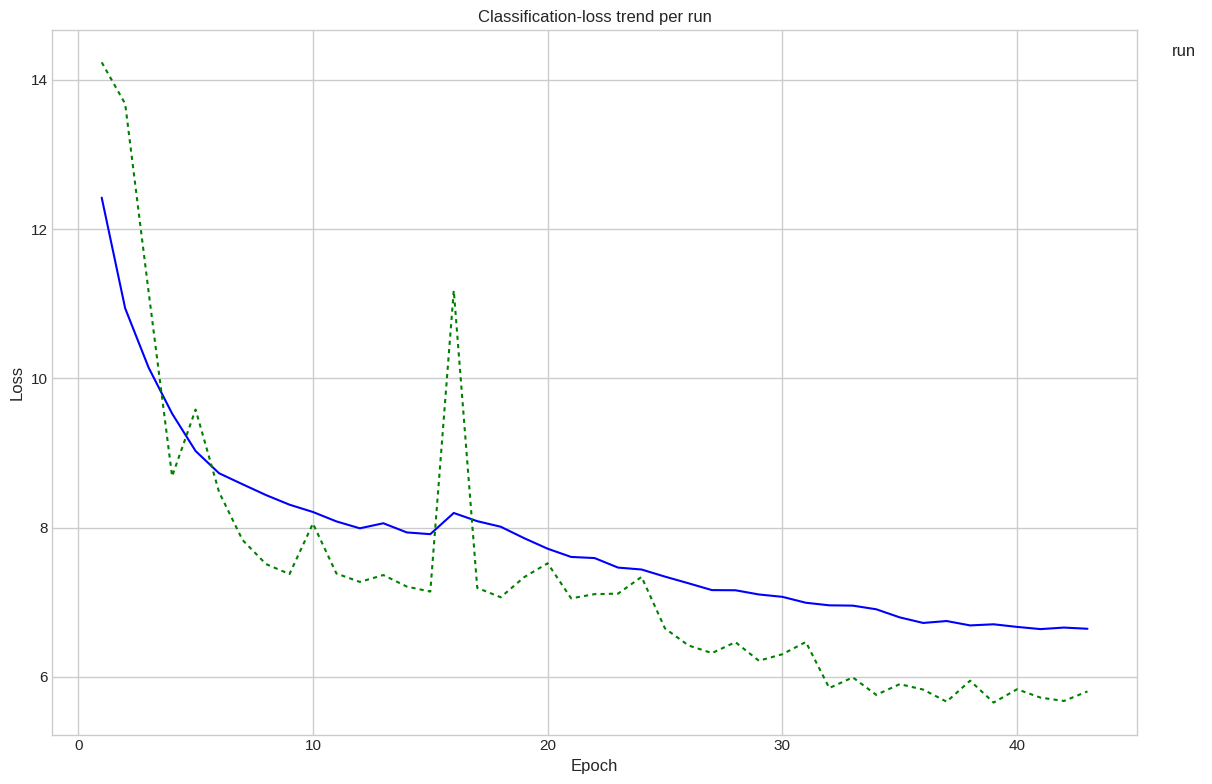

In [73]:
plot_data = []
for run_name, history in all_histories.items():
    for ep in history:
        ep["run_name"] = run_name
        plot_data.append(ep)

df = pd.DataFrame(plot_data)

df["tr_scene_avg"] = df["tr_total"]
df["vl_scene_avg"] = df["vl_total"]

run_names = df["run_name"].unique()
n_runs = len(run_names)

# ------------------------------------ #
# 1.  LOSS curves (classification)      #
# ------------------------------------ #
plt.style.use("seaborn-v0_8-whitegrid")

# Define custom colors for training and validation lines
train_color = "blue"  # Color for training loss lines
val_color = "green"    # Color for validation loss lines

fig, ax1 = plt.subplots(figsize=(15, 8))

# Plot training loss with a specific color
sns.lineplot(
    data=df,
    x="epoch",
    y="tr_total",
    hue="run_name",
    style="run_name",
    dashes=True,
    palette={run: train_color for run in df["run_name"].unique()},  # Assign single color to all runs
    ax=ax1,
    legend=False,
    markersize=7
)

# Plot validation loss with a different color
sns.lineplot(
    data=df,
    x="epoch",
    y="vl_total",
    hue="run_name",
    style="run_name",
    dashes={r: (2, 2) for r in run_names},  # Dashed for validation
    palette={run: val_color for run in df["run_name"].unique()},  # Assign single color to all runs
    ax=ax1,
    legend=False
)

ax1.set(
    title="Classification-loss trend per run",
    xlabel="Epoch",
    ylabel="Loss"
)
ax1.legend(title="run", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout(rect=[0, 0, 0.82, 1])
plt.show()

In [76]:
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import numpy as np
from collections import defaultdict

@torch.no_grad()
def evaluate_model_comprehensive(model, loader, battery_level: float, 
                                apply_posthoc_rule: bool = True,
                                verbose: bool = True):
    """
    Comprehensive evaluation with:
    1. Bug fixes from original code
    2. Per-class analysis 
    3. Confidence distribution analysis
    4. Label encoder verification
    5. Distribution shift detection
    """
    device = next(model.parameters()).device
    model.eval()

    # ---------------- Verify label encoders ----------------
    test_io_classes = list(loader.dataset.io_label_encoder.classes_)
    test_scene_classes = list(loader.dataset.scene_label_encoder.classes_)
    
    # Load training classes from checkpoint for comparison
    try:
        ckpt = torch.load(BEST_MODEL_PATH, map_location=device, weights_only=False)
        train_io_classes = ckpt.get("io_classes", test_io_classes)
        train_scene_classes = ckpt.get("scene_classes", test_scene_classes)
        
        if train_io_classes != test_io_classes:
            print("⚠️  WARNING: I/O label encoders don't match!")
            print(f"Train: {train_io_classes}")
            print(f"Test:  {test_io_classes}")
            
        if train_scene_classes != test_scene_classes:
            print("⚠️  WARNING: Scene label encoders don't match!")
            print(f"Train: {train_scene_classes}")
            print(f"Test:  {test_scene_classes}")
    except:
        print("⚠️  Could not verify label encoder consistency")

    # ---------------- Initialize counters ----------------
    total_samples_count = 0
    exit1_count = 0
    exit2_count = 0
    
    # Overall accuracy counters
    correct_io_exit1_count = 0
    correct_io_exit2_final_count = 0  
    correct_scene_exit2_count = 0
    
    # Per-class tracking
    io_class_stats = defaultdict(lambda: {'total': 0, 'correct': 0})
    scene_class_stats = defaultdict(lambda: {'total': 0, 'correct': 0})
    
    # Confidence tracking
    confidence_by_class = defaultdict(list)
    confidence_by_exit = {'exit1': [], 'exit2': []}
    
    # F1 score lists
    io_true_all, io_pred_final_all = [], []
    io_true_exit2, io_pred_exit2_final = [], []
    io_true_exit2_e0, io_pred_exit2_e0 = [], []
    scene_true_exit2, scene_pred_exit2_raw = [], []
    scene_true_exit2_final, scene_pred_exit2_final = [], []
    
    # Label mapping setup
    scene_encoder = loader.dataset.scene_label_encoder
    io_encoder = loader.dataset.io_label_encoder
    
    try:
        street_label_int = list(scene_encoder.classes_).index('Street')
        outdoor_label_int = list(io_encoder.classes_).index('Outdoor')
    except ValueError as e:
        print(f"⚠️  Label mapping error: {e}")
        street_label_int = 0
        outdoor_label_int = 0

    # Depth permission
    try:
        is_deep_allowed = (allowed_depth(battery_level) != 1)
    except Exception:
        is_deep_allowed = True

    # -------------------------- Main evaluation loop --------------------------
    for feats, io_labels, scene_labels in loader:
        feats = feats.to(device, non_blocking=True).float()
        io_labels = io_labels.view(-1).to(device).long()
        scene_labels = scene_labels.view(-1).to(device).long()
        batch_size = feats.size(0)
        total_samples_count += batch_size

        # Get all outputs
        prev_flag = getattr(model, "if_train", False)
        model.if_train = True
        batt_vec = torch.full((batch_size,), float(battery_level), device=device)
        outputs, _ = model(feats, battery_level=batt_vec)
        model.if_train = prev_flag

        if len(outputs) < 2:
            raise RuntimeError("Model must return at least [e0_io_logits, e1_scene_logits]")

        e0_io_logits = outputs[0]
        e1_scene_logits = outputs[1]
        e1_io_logits = outputs[2] if len(outputs) > 2 else None

        # ---------- Routing decision ----------
        early_confidence = F.softmax(e0_io_logits, dim=-1).amax(dim=-1)
        
        try:
            tau_value = tau_piecewise(battery_level)
            tau_value = float(tau_value.item()) if hasattr(tau_value, "item") else float(tau_value)
        except Exception:
            tau_value = 0.9

        go_deep_mask = (early_confidence < tau_value) & is_deep_allowed
        exit_early_mask = ~go_deep_mask

        exit1_count += int(exit_early_mask.sum().item())
        exit2_count += int(go_deep_mask.sum().item())

        # ---------- Predictions ----------
        e0_io_pred = e0_io_logits.argmax(dim=1)
        
        if e1_io_logits is not None:
            e1_io_pred = e1_io_logits.argmax(dim=1)
        else:
            e1_io_pred = e0_io_pred

        io_final_pred = torch.where(go_deep_mask, e1_io_pred, e0_io_pred)
        
        # Scene predictions (raw and with post-hoc rule)
        scene_pred_raw = e1_scene_logits.argmax(dim=1)
        scene_pred_final = scene_pred_raw.clone()
        
        if apply_posthoc_rule:
            # Apply Outdoor->Street mapping
            outdoor_mask = (io_final_pred == outdoor_label_int)
            scene_pred_final[outdoor_mask] = street_label_int

        # ---------- Confidence tracking ----------
        for i in range(batch_size):
            conf = early_confidence[i].item()
            io_class = io_encoder.classes_[io_labels[i]]
            confidence_by_class[io_class].append(conf)
            
            if exit_early_mask[i]:
                confidence_by_exit['exit1'].append(conf)
            else:
                confidence_by_exit['exit2'].append(conf)

        # ---------- Accuracy computation ----------
        # Early exit I/O accuracy
        if exit_early_mask.any():
            early_correct = (e0_io_pred[exit_early_mask] == io_labels[exit_early_mask])
            correct_io_exit1_count += early_correct.sum().item()
            
            # Per-class stats for early exit
            for i in torch.where(exit_early_mask)[0]:
                io_class = io_encoder.classes_[io_labels[i]]
                io_class_stats[io_class]['total'] += 1
                if early_correct[exit_early_mask.cumsum(0)[i] - 1]:  # Adjust index
                    io_class_stats[io_class]['correct'] += 1

        # Late exit accuracies
        if go_deep_mask.any():
            # I/O accuracy on late subset
            late_io_correct = (io_final_pred[go_deep_mask] == io_labels[go_deep_mask])
            correct_io_exit2_final_count += late_io_correct.sum().item()
            
            # Scene accuracy on late subset  
            late_scene_correct = (scene_pred_final[go_deep_mask] == scene_labels[go_deep_mask])
            correct_scene_exit2_count += late_scene_correct.sum().item()
            
            # Per-class stats for late samples
            late_indices = torch.where(go_deep_mask)[0]
            for i, late_idx in enumerate(late_indices):
                # I/O class stats
                io_class = io_encoder.classes_[io_labels[late_idx]]
                io_class_stats[io_class]['total'] += 1
                if late_io_correct[i]:
                    io_class_stats[io_class]['correct'] += 1
                
                # Scene class stats
                scene_class = scene_encoder.classes_[scene_labels[late_idx]]
                scene_class_stats[scene_class]['total'] += 1
                if late_scene_correct[i]:
                    scene_class_stats[scene_class]['correct'] += 1

            # Collect for F1 scores
            io_true_exit2.extend(io_labels[go_deep_mask].tolist())
            io_pred_exit2_final.extend(io_final_pred[go_deep_mask].tolist())
            io_true_exit2_e0.extend(io_labels[go_deep_mask].tolist())
            io_pred_exit2_e0.extend(e0_io_pred[go_deep_mask].tolist())
            
            scene_true_exit2.extend(scene_labels[go_deep_mask].tolist())
            scene_pred_exit2_raw.extend(scene_pred_raw[go_deep_mask].tolist())
            scene_true_exit2_final.extend(scene_labels[go_deep_mask].tolist())
            scene_pred_exit2_final.extend(scene_pred_final[go_deep_mask].tolist())

        # Overall I/O for F1
        io_true_all.extend(io_labels.tolist())
        io_pred_final_all.extend(io_final_pred.tolist())
        
        # Per-class I/O stats for all samples (update totals for early samples above)
        for i in range(batch_size):
            if not go_deep_mask[i]:  # Early exit samples not yet counted
                continue  # Already handled above

    # -------------------------- Final computations --------------------------
    total = total_samples_count
    
    # Accuracy rates
    acc_io_exit1 = (correct_io_exit1_count / exit1_count) if exit1_count else 0.0
    acc_io_exit2_final = (correct_io_exit2_final_count / exit2_count) if exit2_count else 0.0  
    acc_scene_exit2 = (correct_scene_exit2_count / exit2_count) if exit2_count else 0.0

    # F1 scores
    f1_io_final_all = f1_score(io_true_all, io_pred_final_all, average='weighted', zero_division=0) if io_true_all else 0.0
    f1_io_exit2_final = f1_score(io_true_exit2, io_pred_exit2_final, average='weighted', zero_division=0) if io_true_exit2 else 0.0
    f1_io_exit2_e0 = f1_score(io_true_exit2_e0, io_pred_exit2_e0, average='weighted', zero_division=0) if io_true_exit2_e0 else 0.0
    f1_scene_exit2_raw = f1_score(scene_true_exit2, scene_pred_exit2_raw, average='weighted', zero_division=0) if scene_true_exit2 else 0.0
    f1_scene_exit2_final = f1_score(scene_true_exit2_final, scene_pred_exit2_final, average='weighted', zero_division=0) if scene_true_exit2_final else 0.0

    # Per-class accuracies
    io_class_accuracies = {}
    scene_class_accuracies = {}
    
    for cls, stats in io_class_stats.items():
        io_class_accuracies[cls] = stats['correct'] / stats['total'] if stats['total'] > 0 else 0.0
        
    for cls, stats in scene_class_stats.items():
        scene_class_accuracies[cls] = stats['correct'] / stats['total'] if stats['total'] > 0 else 0.0

    # Confidence statistics
    confidence_stats = {}
    for cls, confs in confidence_by_class.items():
        if confs:
            confidence_stats[cls] = {
                'mean': np.mean(confs),
                'std': np.std(confs),
                'min': np.min(confs),
                'max': np.max(confs)
            }

    exit_confidence_stats = {}
    for exit_name, confs in confidence_by_exit.items():
        if confs:
            exit_confidence_stats[exit_name] = {
                'mean': np.mean(confs),
                'std': np.std(confs),
                'count': len(confs)
            }

    results = {
        "battery_level": battery_level,
        "coverage": {
            "exit1_pct": (exit1_count / total * 100.0) if total else 0.0,
            "exit2_pct": (exit2_count / total * 100.0) if total else 0.0,
        },
        "accuracy": {
            "io_exit1": acc_io_exit1,
            "io_exit2_final": acc_io_exit2_final,
            "scene_exit2": acc_scene_exit2,
        },
        "per_class_accuracy": {
            "io": io_class_accuracies,
            "scene": scene_class_accuracies
        },
        "per_class_counts": {
            "io": dict(io_class_stats),
            "scene": dict(scene_class_stats)
        },
        "f1_weighted": {
            "io_final_all": f1_io_final_all,
            "io_exit2_final": f1_io_exit2_final,
            "io_exit2_e0_baseline": f1_io_exit2_e0,
            "scene_exit2_raw": f1_scene_exit2_raw,
            "scene_exit2_final": f1_scene_exit2_final,
        },
        "confidence_analysis": {
            "by_class": confidence_stats,
            "by_exit": exit_confidence_stats,
            "threshold_used": tau_value
        },
        "counts": {
            "total": total,
            "exit1": exit1_count,
            "exit2": exit2_count,
        }
    }

    # Verbose reporting
    if verbose:
        print_detailed_results(results)

    return results

def print_detailed_results(results):
    """Print comprehensive results with distribution analysis"""
    print(f"\n{'='*70}")
    print(f"COMPREHENSIVE EVALUATION @ Battery Level {results['battery_level']:.2f}")
    print(f"{'='*70}")
    
    # Coverage
    coverage = results['coverage']
    print(f"\n📊 Exit Coverage:")
    print(f"  Exit 1 (Early): {coverage['exit1_pct']:.1f}% ({results['counts']['exit1']} samples)")
    print(f"  Exit 2 (Late):  {coverage['exit2_pct']:.1f}% ({results['counts']['exit2']} samples)")
    
    # Overall accuracy
    acc = results['accuracy']
    print(f"\n🎯 Overall Accuracy:")
    print(f"  I/O @ Exit 1:     {acc['io_exit1']:.3f}")
    print(f"  I/O @ Exit 2:     {acc['io_exit2_final']:.3f}")
    print(f"  Scene @ Exit 2:   {acc['scene_exit2']:.3f}")
    
    # Per-class breakdown
    print(f"\n📋 Per-Class I/O Accuracy:")
    io_acc = results['per_class_accuracy']['io']
    io_counts = results['per_class_counts']['io']
    for cls in sorted(io_acc.keys()):
        acc_val = io_acc[cls]
        counts = io_counts[cls]
        print(f"  {cls:>8}: {acc_val:.3f} ({counts['correct']:>4}/{counts['total']:>4})")
    
    if results['per_class_accuracy']['scene']:
        print(f"\n📋 Per-Class Scene Accuracy:")
        scene_acc = results['per_class_accuracy']['scene']  
        scene_counts = results['per_class_counts']['scene']
        for cls in sorted(scene_acc.keys()):
            acc_val = scene_acc[cls]
            counts = scene_counts[cls]
            print(f"  {cls:>8}: {acc_val:.3f} ({counts['correct']:>4}/{counts['total']:>4})")
    
    # Confidence analysis
    conf_analysis = results['confidence_analysis']
    print(f"\n🎲 Confidence Analysis (Threshold: {conf_analysis['threshold_used']:.3f}):")
    
    if 'by_class' in conf_analysis:
        print("  By Class:")
        for cls, stats in conf_analysis['by_class'].items():
            print(f"    {cls:>8}: μ={stats['mean']:.3f}, σ={stats['std']:.3f}")
    
    if 'by_exit' in conf_analysis:
        print("  By Exit:")
        for exit_name, stats in conf_analysis['by_exit'].items():
            print(f"    {exit_name:>8}: μ={stats['mean']:.3f}, σ={stats['std']:.3f}, n={stats['count']}")
    
    # F1 scores
    f1 = results['f1_weighted']
    print(f"\n🏆 Weighted F1 Scores:")
    print(f"  I/O (All samples):     {f1['io_final_all']:.3f}")
    print(f"  I/O (Late final):      {f1['io_exit2_final']:.3f}")  
    print(f"  I/O (Late E0 baseline): {f1['io_exit2_e0_baseline']:.3f}")
    print(f"  Scene (Raw):           {f1['scene_exit2_raw']:.3f}")
    print(f"  Scene (Final):         {f1['scene_exit2_final']:.3f}")

# Fixed usage code
def run_comprehensive_evaluation():
    """Run the comprehensive evaluation with proper error handling"""
    
    # Load model properly
    BEST_MODEL_PATH = "/kaggle/working/validation_runs/LR_0.001_WD_0.0003_SCH_cosine_X114/best_model.pth"
    
    try:
        ckpt = torch.load(BEST_MODEL_PATH, map_location=device, weights_only=False)
        print(f"✅ Successfully loaded checkpoint from {BEST_MODEL_PATH}")
        
        model = DepthwiseEarlyExitCNN1D(
            if_train=False,
            train_shape=ckpt.get("train_shape", train_loader.dataset[0][0].shape),
            n_io=len(ckpt.get("io_classes", train_dataset.io_label_encoder.classes_)),
            n_scene=len(ckpt.get("scene_classes", train_dataset.scene_label_encoder.classes_))
        ).to(device)

        state = ckpt["model"] if "model" in ckpt else ckpt
        model.load_state_dict(state, strict=True)
        print(f"✅ Model loaded with {sum(p.numel() for p in model.parameters()):,} parameters")
        
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return

    # Test at multiple battery levels
    battery_levels = [0.3, 0.6, 0.9, 1.0]
    
    for battery_level in battery_levels:
        try:
            results = evaluate_model_comprehensive(
                model, test_loader, battery_level, 
                apply_posthoc_rule=True, verbose=True
            )
            print(f"\n{'='*70}\n")
            
        except Exception as e:
            print(f"❌ Error during evaluation at battery {battery_level}: {e}")
            import traceback
            traceback.print_exc()

# Run the evaluation
run_comprehensive_evaluation()

✅ Successfully loaded checkpoint from /kaggle/working/validation_runs/LR_0.001_WD_0.0003_SCH_cosine_X114/best_model.pth
✅ Model loaded with 24,752 parameters

COMPREHENSIVE EVALUATION @ Battery Level 0.30

📊 Exit Coverage:
  Exit 1 (Early): 38.2% (2041 samples)
  Exit 2 (Late):  61.8% (3301 samples)

🎯 Overall Accuracy:
  I/O @ Exit 1:     0.981
  I/O @ Exit 2:     0.904
  Scene @ Exit 2:   0.768

📋 Per-Class I/O Accuracy:
    Indoor: 0.946 (3604/3809)
   Outdoor: 0.902 (1382/1533)

📋 Per-Class Scene Accuracy:
       Bar: 0.825 ( 477/ 578)
   Hallway: 0.814 ( 767/ 942)
    Office: 0.484 ( 339/ 701)
    Street: 0.881 ( 951/1080)

🎲 Confidence Analysis (Threshold: 0.850):
  By Class:
      Indoor: μ=0.786, σ=0.132
     Outdoor: μ=0.747, σ=0.146
  By Exit:
       exit1: μ=0.910, σ=0.034, n=2041
       exit2: μ=0.691, σ=0.107, n=3301

🏆 Weighted F1 Scores:
  I/O (All samples):     0.934
  I/O (Late final):      0.904
  I/O (Late E0 baseline): 0.740
  Scene (Raw):           0.772
  Scene (F

All-samples Exit2 classification report:
              precision    recall  f1-score   support

         Bar      0.481     0.768     0.592       828
     Hallway      0.799     0.809     0.804      1097
      Office      0.871     0.715     0.786      1884
      Street      0.847     0.753     0.797      1533

    accuracy                          0.754      5342
   macro avg      0.750     0.761     0.745      5342
weighted avg      0.789     0.754     0.763      5342



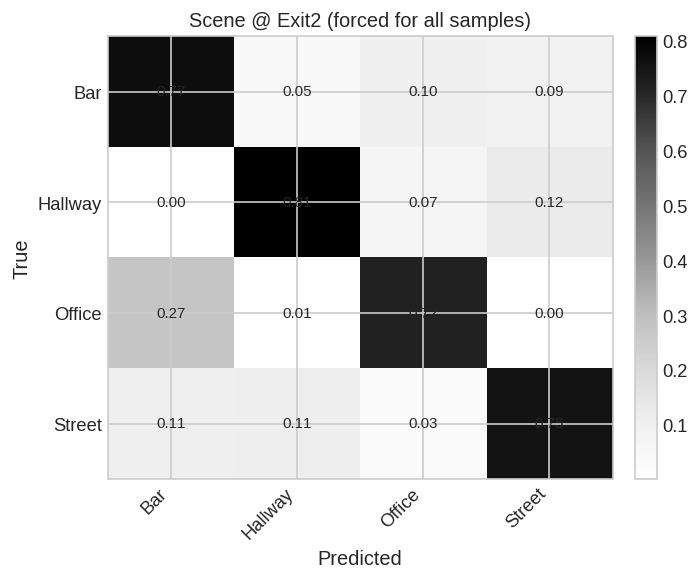

In [19]:
from sklearn.metrics import confusion_matrix, classification_report

@torch.no_grad()
def collect_scene_preds_exit2(model, loader, device, battery_level=1.0, force_exit2=True):
    """
    Returns:
        y_true: np.array of true scene labels
        y_pred: np.array of predicted scene labels at exit2
        used_idx: indices of samples actually evaluated (important if force_exit2=False)
    """
    model.eval()
    y_true, y_pred, used_idx = [], [], []
    idx = 0

    for batch in loader:
        # Your dataset order was (feats, io_lbls, sc_lbls) in many snippets
        if len(batch) == 3:
            feats, io_lbls, sc_lbls = batch
        else:
            # If your loader yields dicts or different tuples, adapt here
            raise ValueError("Expected (feats, io_lbls, sc_lbls) from the loader.")

        feats = feats.to(device, non_blocking=True).float()
        sc_lbls = sc_lbls.to(device, non_blocking=True).long()

        if force_exit2:
            # Trick: set if_train=True temporarily to always fetch e1sc (exit2 scene logits)
            was_train_flag = model.if_train
            model.if_train = True
            out_list, _ = model(feats, battery_level=battery_level)
            model.if_train = was_train_flag

            e1sc = out_list[1]          # [B, n_scene]
            pred = e1sc.argmax(dim=1)   # scene prediction at exit2 for all samples

            y_true.append(sc_lbls.cpu().numpy())
            y_pred.append(pred.cpu().numpy())
            used_idx.extend(range(idx, idx + sc_lbls.shape[0]))

        else:
            # Policy-based: only include samples that actually go deep in normal inference
            was_train_flag = model.if_train
            model.if_train = False
            out_list, exit_id = model(feats, battery_level=battery_level)
            model.if_train = was_train_flag

            # exit_id can be scalar or per-sample; in your code it’s a scalar for the whole batch.
            if exit_id == 2:
                # out_list = [io_final, e1sc]
                e1sc = out_list[1]
                pred = e1sc.argmax(dim=1)
                y_true.append(sc_lbls.cpu().numpy())
                y_pred.append(pred.cpu().numpy())
                used_idx.extend(range(idx, idx + sc_lbls.shape[0]))
            # else: all samples exited early → nothing added (this is expected)

        idx += sc_lbls.shape[0]

    if len(y_true) == 0:
        # No samples reached exit2 in policy mode
        return np.array([]), np.array([]), np.array(used_idx, dtype=int)

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    return y_true, y_pred, np.array(used_idx, dtype=int)


def plot_confusion_heatmap(y_true, y_pred, class_names, normalize=True, title="Scene @ Exit2"):
    """
    Draws a single heatmap using matplotlib (no seaborn).
    normalize=True shows per-row (true class) normalization.
    """
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    if normalize:
        cm = cm.astype(np.float64)
        row_sums = cm.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1.0
        cm = cm / row_sums

    fig, ax = plt.subplots(figsize=(6, 5), dpi=120)
    im = ax.imshow(cm, aspect='auto')
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    ax.set_xticks(range(len(class_names)))
    ax.set_yticks(range(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_yticklabels(class_names)

    # Annotate cells
    h, w = cm.shape
    for i in range(h):
        for j in range(w):
            val = cm[i, j]
            text = f"{val:.2f}" if normalize else f"{int(val)}"
            ax.text(j, i, text, va='center', ha='center', fontsize=9)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    return fig

class_names = list(test_loader.dataset.scene_label_encoder.classes_)  # or your own list

BEST_MODEL_PATH = "/kaggle/working/validation_runs/LR_0.0003_WD_5e-05_SCH_step_X113/best_model.pth"

model = DepthwiseEarlyExitCNN1D(
    if_train=False,
    train_shape=train_loader.dataset[0][0].shape,
    n_io=len(train_dataset.io_label_encoder.classes_),
    n_scene=len(train_dataset.scene_label_encoder.classes_)
).to(device)

# Load the weights of your chosen best model
model.load_state_dict(torch.load(BEST_MODEL_PATH))

# 1) FORCE exit2: evaluate scene head on all samples
y_true_all, y_pred_all, idx_all = collect_scene_preds_exit2(model, test_loader, device, battery_level=1.0, force_exit2=True)
print("All-samples Exit2 classification report:")
print(classification_report(y_true_all, y_pred_all, target_names=class_names, digits=3))
fig1 = plot_confusion_heatmap(y_true_all, y_pred_all, class_names, normalize=True, title="Scene @ Exit2 (forced for all samples)")
plt.show()

In [32]:
@torch.no_grad()
def collect_scene_preds_exit2(model, loader, device, battery_level=1.0, force_exit2=True):
    """
    Returns:
        y_true: np.array of true scene labels
        y_pred: np.array of predicted scene labels at exit2
        used_idx: indices of samples actually evaluated (important if force_exit2=False)
    """
    model.eval()
    y_true, y_pred, used_idx = [], [], []
    idx = 0

    for batch in loader:
        # Your dataset order was (feats, io_lbls, sc_lbls) in many snippets
        if len(batch) == 3:
            feats, io_lbls, sc_lbls = batch
        else:
            # If your loader yields dicts or different tuples, adapt here
            raise ValueError("Expected (feats, io_lbls, sc_lbls) from the loader.")

        feats = feats.to(device, non_blocking=True).float()
        sc_lbls = sc_lbls.to(device, non_blocking=True).long()

        if force_exit2:
            # Trick: set if_train=True temporarily to always fetch e1sc (exit2 scene logits)
            was_train_flag = model.if_train
            model.if_train = True
            out_list, _ = model(feats, battery_level=battery_level)
            model.if_train = was_train_flag

            e1sc = out_list[1]          # [B, n_scene]
            pred = e1sc.argmax(dim=1)   # scene prediction at exit2 for all samples

            y_true.append(sc_lbls.cpu().numpy())
            y_pred.append(pred.cpu().numpy())
            used_idx.extend(range(idx, idx + sc_lbls.shape[0]))

        else:
            # Policy-based: only include samples that actually go deep in normal inference
            was_train_flag = model.if_train
            model.if_train = False
            out_list, exit_id = model(feats, battery_level=battery_level)
            model.if_train = was_train_flag

            # exit_id can be scalar or per-sample; in your code it’s a scalar for the whole batch.
            if exit_id == 2:
                # out_list = [io_final, e1sc]
                e1sc = out_list[1]
                pred = e1sc.argmax(dim=1)
                y_true.append(sc_lbls.cpu().numpy())
                y_pred.append(pred.cpu().numpy())
                used_idx.extend(range(idx, idx + sc_lbls.shape[0]))
            # else: all samples exited early → nothing added (this is expected)

        idx += sc_lbls.shape[0]

    if len(y_true) == 0:
        # No samples reached exit2 in policy mode
        return np.array([]), np.array([]), np.array(used_idx, dtype=int)

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    return y_true, y_pred, np.array(used_idx, dtype=int)


def plot_confusion_heatmap(y_true, y_pred, class_names, normalize=True, title="Scene @ Exit2"):
    """
    Draws a single heatmap using matplotlib (no seaborn).
    normalize=True shows per-row (true class) normalization.
    """
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    if normalize:
        cm = cm.astype(np.float64)
        row_sums = cm.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1.0
        cm = cm / row_sums

    fig, ax = plt.subplots(figsize=(6, 5), dpi=120)
    im = ax.imshow(cm, aspect='auto')
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    ax.set_xticks(range(len(class_names)))
    ax.set_yticks(range(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_yticklabels(class_names)

    # Annotate cells
    h, w = cm.shape
    for i in range(h):
        for j in range(w):
            val = cm[i, j]
            text = f"{val:.2f}" if normalize else f"{int(val)}"
            ax.text(j, i, text, va='center', ha='center', fontsize=9)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    return fig


# ---------------------- HOW TO USE --------------------------------
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# class_names = list(test_loader.dataset.scene_label_encoder.classes_)  # or your own list
#
# # 1) FORCE exit2: evaluate scene head on all samples
# y_true_all, y_pred_all, idx_all = collect_scene_preds_exit2(
#     model, test_loader, device, battery_level=1.0, force_exit2=True
# )
# print("All-samples Exit2 classification report:")
# print(classification_report(y_true_all, y_pred_all, target_names=class_names, digits=3))
# fig1 = plot_confusion_heatmap(y_true_all, y_pred_all, class_names, normalize=True,
#                               title="Scene @ Exit2 (forced for all samples)")
# plt.show()

In [ ]:
def evaluate_sensor_subset(model, loader, battery_level, sensor_slices, active_sensors):
    model.eval()
    model.if_train = False

    # Grab one batch just to get C and T
    T, C = loader.dataset[0][0].shape

    mask = torch.zeros(1, 1, C, device=device)
    for i in active_sensors:
        c0, c1 = sensor_slices[i]
        mask[..., c0:c1] = 1
        
    # Build hard mask on channel dim: shape (1, C, 1)
    # mask = torch.zeros(1, C, 1, device=device)
    # for i in active_sensors:
    #     c0, c1 = sensor_slices[i]
    #     mask[:, c0:c1, :] = 1

    total = 0
    exit_counts = {1: 0, 2: 0, 3: 0}
    correct_exit = {1: 0, 2: 0, 3: 0}
    y_true = {1: [], 2: [], 3: []}
    y_pred = {1: [], 2: [], 3: []}

    with torch.no_grad():
        for feats, io_lbls, sc_lbls in loader:
            # feats: (B, T, C)
            feats = feats.float().to(device) * mask   # still (B, T, C)
            io_lbls = io_lbls.view(-1).to(device)
            sc_lbls = sc_lbls.view(-1).to(device)
            bsz = feats.size(0)

            batt = torch.full((bsz,), battery_level, dtype=torch.float32, device=device)
            outs, exit_idx = model(feats, battery_level=batt)
            exit_idx = int(exit_idx)

            total += bsz
            exit_counts[exit_idx] += bsz

            if exit_idx == 1:
                preds = outs[0].argmax(dim=1); labels = io_lbls
            elif exit_idx == 2:
                preds = outs[1].argmax(dim=1); labels = sc_lbls
            else:
                preds = outs[2].argmax(dim=1); labels = sc_lbls

            correct_exit[exit_idx] += (preds == labels).sum().item()
            y_true[exit_idx].extend(labels.cpu().tolist())
            y_pred[exit_idx].extend(preds.cpu().tolist())

    # summarize
    exit_rates = {e: exit_counts[e]/total*100 for e in exit_counts}
    accuracy_at_exit = {
        e: correct_exit[e]/exit_counts[e] if exit_counts[e] else 0.0
        for e in exit_counts
    }
    overall_acc = sum(correct_exit.values()) / total

    f1_at_exit = {}
    for e in exit_counts:
        if exit_counts[e]:
            f1_at_exit[e] = f1_score(
                y_true[e], y_pred[e], average="macro", zero_division=0
            )
        else:
            f1_at_exit[e] = 0.0

    all_true = sum(y_true.values(), [])
    all_pred = sum(y_pred.values(), [])
    overall_f1 = (
        f1_score(all_true, all_pred, average="macro", zero_division=0)
        if total else 0.0
    )

    return {
        "active_sensors": active_sensors,
        "exit_rates":        exit_rates,
        "accuracy_at_exit":  accuracy_at_exit,
        "overall_acc":       overall_acc,
        "f1_at_exit":        f1_at_exit,
        "overall_f1":        overall_f1
    }

# FIX this

In [47]:
BEST_MODEL_PATH = "/kaggle/working/validation_runs/LR_0.0003_WD_5e-05_SCH_step_DROP_0.0_X100/best_model.pth"

model = DepthwiseEarlyExitCNN1D(
    if_train=False,
    train_shape=train_loader.dataset[0][0].shape,
    n_io=len(train_dataset.io_label_encoder.classes_),
    n_scene=len(train_dataset.scene_label_encoder.classes_),
    drop_p=hparams["drop_p"]
).to(device)

# Load the weights of your chosen best model
model.load_state_dict(torch.load(BEST_MODEL_PATH))

# battery_levels = np.linspace(0, 1, 11)

sensor_slices = [
    ( 0,  3),  # Acc: channels 0,1,2
    ( 3,  6),  # Mag: 3,4,5
    ( 6,  9),  # Gyro:6,7,8
    ( 9, 10),  # Press:9
    (10, 11),  # Temp:10
]
sensors_name = ["Acc", "Mag", "Gyro", "Press", "Temp"] # check the order of sensors
keep_sensors = [0, 1]

# keep only sensors[0] and sensors[1]
result = evaluate_sensor_subset(
    model=model,
    loader=test_loader,
    battery_level=1.0,
    sensor_slices=sensor_slices,
    active_sensors=list(range(len(sensor_slices)))
)

# Build list of kept sensor names
kept = [sensors_name[i] for i in keep_sensors]
print("Kept sensors:", ", ".join(kept))
print(f"Exit rates: {result['exit_rates']}")
print(f"Accuracy at exits: {result['accuracy_at_exit']}")
print(f"Overall accuracy: {result['overall_acc']:.3f}")

NameError: name 'evaluate_sensor_subset' is not defined

In [ ]:
import itertools
import json
import os

train_shape = train_ds[0][0].shape

model = DepthwiseEarlyExitCNN1D(
    if_train=True,
    train_shape=train_shape,
    n_io=len(train_ds.io_label_encoder.classes_),
    n_scene=len(train_ds.scene_label_encoder.classes_)
).to(device)

# Load the weights of your chosen best model
model.load_state_dict(torch.load(BEST_MODEL_PATH))

sensor_slices = [(0,6), (6,9), (9,12), (12,13), (13,14)]
sensor_indices = [0, 1, 2, 3, 4]
sensor_names = ["Acc", "Mag", "Gyro", "Press", "Temp"]

# Generate all non-empty subsets (combinations) of sensor indices
all_combinations = [
    list(combo)
    for r in range(1, len(sensor_indices) + 1)
    for combo in itertools.combinations(sensor_indices, r)
]

# Evaluate each combination and collect results
results = []
i = 1
for combo in all_combinations:
    print(f"Iteration {i}/{len(all_combinations)} Evaluating combo: {combo}")
    # Evaluate the model on this subset
    res = evaluate_sensor_subset(
        model=model,
        loader=test_loader,
        battery_level=0.5,
        sensor_slices=sensor_slices,
        active_sensors=combo
    )
    # Map indices to names for readability
    res["active_sensor_names"] = [sensor_names[i] for i in combo]
    results.append(res)

    i += 1

# Define output filepath
output_path = "/kaggle/working/b_1.0.json"

# Save results to JSON
with open(output_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"Saved evaluation results for {len(results)} combinations")

## Evaluating performance

In [70]:
def count_parameters(model):
    """Counts the total number of trainable parameters in a PyTorch model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Load model properly
    BEST_MODEL_PATH = "/kaggle/working/validation_runs/LR_0.001_WD_0.0001_SCH_cosine_X114/best_model.pth"
    
    try:
        ckpt = torch.load(BEST_MODEL_PATH, map_location=device, weights_only=False)
        print(f"✅ Successfully loaded checkpoint from {BEST_MODEL_PATH}")
        
        model = DepthwiseEarlyExitCNN1D(
            if_train=False,
            train_shape=ckpt.get("train_shape", train_loader.dataset[0][0].shape),
            n_io=len(ckpt.get("io_classes", train_dataset.io_label_encoder.classes_)),
            n_scene=len(ckpt.get("scene_classes", train_dataset.scene_label_encoder.classes_))
        ).to(device)

        state = ckpt["model"] if "model" in ckpt else ckpt
        model.load_state_dict(state, strict=True)
        print(f"✅ Model loaded with {sum(p.numel() for p in model.parameters()):,} parameters")
        
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return

# Now, call the function to get the count
total_params = count_parameters(model)
print(f"Total Trainable Parameters: {total_params:}")

estimated_size = total_params * 4 / 1000 # FP32 precision
print(f"Estimated Size: {estimated_size:,} KB")

Total Trainable Parameters: 24752
Estimated Size: 99.008 KB


In [75]:
from torchinfo import summary

x0 = train_loader.dataset[0][0]
print(x0.shape)

model = DepthwiseEarlyExitCNN1D(
    if_train=False,
    train_shape=train_loader.dataset[0][0].shape,
    n_io=len(train_dataset.io_label_encoder.classes_),
    n_scene=len(train_dataset.scene_label_encoder.classes_)
).to(device)

# Print summary
summary(
    model,
    input_size=(1, 600, 11), 
    col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
    verbose=2,  # Detailed output
    device=device
)

torch.Size([600, 11])
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
DepthwiseEarlyExitCNN1D                  [1, 600, 11]              [1, 2]                    --                        --                        --
├─Sequential: 1-1                        [1, 11, 600]              [1, 16, 150]              --                        --                        --
│    └─0.0.weight                                                                            ├─66                      [11, 1, 6]
│    └─0.1.weight                                                                            ├─11                      [11]
│    └─0.1.bias                                                                              ├─11                      [11]
│    └─0.3.weight                                                                            ├─176                     [16, 11, 1]
│    └─0.4.weight 

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
DepthwiseEarlyExitCNN1D                  [1, 600, 11]              [1, 2]                    --                        --                        --
├─Sequential: 1-1                        [1, 11, 600]              [1, 16, 150]              --                        --                        --
│    └─0.0.weight                                                                            ├─66                      [11, 1, 6]
│    └─0.1.weight                                                                            ├─11                      [11]
│    └─0.1.bias                                                                              ├─11                      [11]
│    └─0.3.weight                                                                            ├─176                     [16, 11, 1]
│    └─0.4.weight                       

# TO DELETE THE /kaggle/working/ FILES

In [48]:
import shutil
import os

directory_path = "/kaggle/working/validation_runs/"

if os.path.exists(directory_path):
    shutil.rmtree(directory_path)
    print(f"Deleted directory {directory_path}")
else:
    print(f"Directory {directory_path} not found")

Deleted directory /kaggle/working/validation_runs/
